In [1]:
# Import required libraries
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [2]:
# Load the dataset
dataset = pd.read_csv("vehicles.csv")

<h2>Data Cleaning</h2>

In [3]:
dataset.describe()

,id,price,year,odometer,county,lat,long
count,4.358490e+05,4.358490e+05,434732.000000,3.607010e+05,0.0,427614.000000,427614.000000
mean,7.115954e+09,1.349127e+05,2009.866460,9.897590e+04,NaN,38.404163,-94.961170
std,4.590854e+06,1.690857e+07,9.312503,1.134990e+05,NaN,6.036915,18.058561
min,7.096577e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-83.197100,-177.012000
25%,7.112450e+09,4.900000e+03,2007.000000,4.733300e+04,NaN,34.225700,-111.731000
50%,7.117092e+09,9.995000e+03,2012.000000,9.118800e+04,NaN,38.934800,-89.676700
75%,7.120090e+09,1.798900e+04,2015.000000,1.347360e+05,NaN,42.484500,-81.397300
max,7.121608e+09,3.647257e+09,2021.000000,1.000000e+07,NaN,79.601900,173.675000


From the above information, following are the observations:
<ol>
    <li>Number of entries in the dataset is close to 4,36000.</li>
    <li>In the price column, the minimum value is 0 which implies that there are free cars available. These entires should be removed from the dataset. Similarly, the maximum value is 3.6 billion which is clearly an outlier.</li>
    <li>The maximum value of odometer column is 10 million miles which should again be an outlier.</li>
    <li>The column "county" is totally empty.</li>
</ol>

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435849 entries, 0 to 435848
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            435849 non-null  int64  
 1   url           435849 non-null  object 
 2   region        435849 non-null  object 
 3   region_url    435849 non-null  object 
 4   price         435849 non-null  int64  
 5   year          434732 non-null  float64
 6   manufacturer  415102 non-null  object 
 7   model         429650 non-null  object 
 8   condition     249043 non-null  object 
 9   cylinders     269465 non-null  object 
 10  fuel          432858 non-null  object 
 11  odometer      360701 non-null  float64
 12  title_status  434043 non-null  object 
 13  transmission  433703 non-null  object 
 14  vin           239197 non-null  object 
 15  drive         313838 non-null  object 
 16  size          139888 non-null  object 
 17  type          318741 non-null  object 
 18  pain

It is observed that there are many missing values in the dataset among the features.

<h2>Removal of Outliers in Price</h2>

<AxesSubplot:title={'center':'Box plot of the prices'}, xlabel='price'>

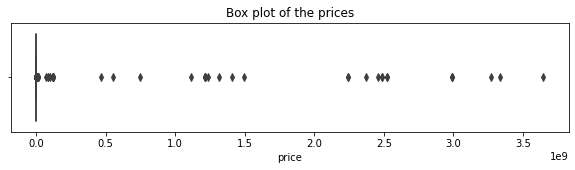

In [5]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_title('Box plot of the prices')
sns.boxplot(x='price', data = dataset)

From the above box plot for price, we can see that there are some outliers present which need to be removed. In this case, we are using interquartile range to remove the outliers.   

In [6]:
Q1 = dataset['price'].quantile(0.25)
Q3 = dataset['price'].quantile(0.75)
IQR = Q3 - Q1
dataset = dataset[(dataset.price >= Q1-1.5*IQR)&(dataset.price <= Q3+1.5*IQR)]

<AxesSubplot:title={'center':'Distribution of the prices'}, xlabel='price'>

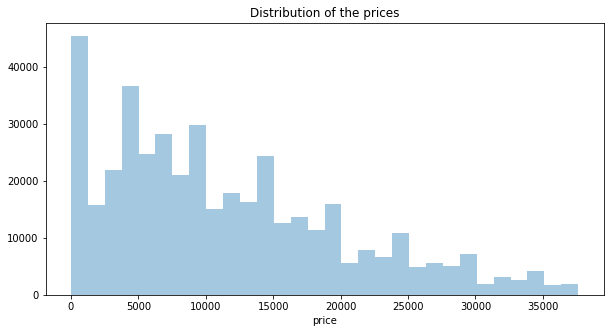

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Distribution of the prices')
sns.distplot(dataset['price'], bins=30, kde=False)

From the above plot, we could observe that there are a lot of cars with zero price. Those entries should also be removed from the dataset. We are setting a threshold of $600.   

In [8]:
dataset = dataset[dataset['price']>600]

In [9]:
dataset.count()['id']

379700

<h2>Removal of Outliers in Odometer</h2>

<AxesSubplot:title={'center':'Box plot of the odometer'}, xlabel='odometer'>

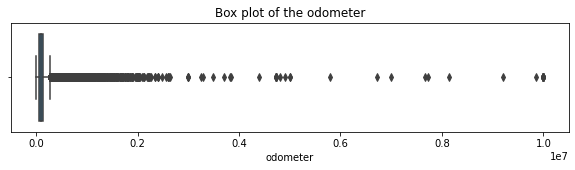

In [10]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_title('Box plot of the odometer')
sns.boxplot(x='odometer', data = dataset)

Similar to the price column, we can see that there are outliers present in the odometer column as well which will be removed using interquartile range. For the odometer column, we accept extremely low values as there can be new cars with such lower values in the dataset. 

In [11]:
Q1 = dataset['odometer'].quantile(0.25)
Q3 = dataset['odometer'].quantile(0.75)
IQR = Q3 - Q1
dataset = dataset[dataset['odometer'] <= Q3 + 3*IQR]

In [12]:
dataset.count()['id'] 

316257

<h2>Removal of features not related to car prices</h2>

In [13]:
dataset.drop(columns = ['id', 'url', 'region', 'region_url', 'title_status', 'vin', 'image_url', 'description', 'county', 'state', 'long', 'lat'], inplace=True)

Out of the two columns 'model' and 'manufacturer', only the column 'model' is sufficient. The column 'manufacturer' is not needed for our prediction as each car model only belongs to one manufacturer.  

In [14]:
dataset_manu = dataset['manufacturer'].to_frame()

In [15]:
dataset.drop(columns = ['manufacturer'], inplace=True)

<h2>Handling of missing values in the dataset</h2>

In [16]:
#Finding the percentage of missing values in each feature
dataset.isnull().sum()*100/len(dataset)

price            0.000000
year             0.174225
model            0.862590
condition       36.541167
cylinders       31.878188
fuel             0.751288
odometer         0.000000
transmission     0.520463
drive           20.289511
size            65.134052
type            18.563067
paint_color     23.309840
dtype: float64

It is observed that: 
<li>Column 'size' has too much of missing values in the dataset. So, it has to be removed. </li>
<li>Columns such as year, model, fuel, transmission, drive, type and paint_color contain very few missing values. So, those corresponding rows have to be removed.</li>
<li>For columns such as condition and cylinders, we decide to keep the missing values by replacing them with 'null' values.</li>

In [17]:
dataset.drop(columns = ['size'], inplace=True)

In [18]:
remove_rows = ['year', 'model', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for column in remove_rows:
    dataset = dataset[~dataset[column].isnull()]

In [19]:
dataset.replace(np.nan, 'null', inplace=True)

In [20]:
#Finding the percentage of missing values in each feature after handling
dataset.isnull().sum()*100/len(dataset)

price           0.0
year            0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
transmission    0.0
drive           0.0
type            0.0
paint_color     0.0
dtype: float64

<h2>Removal of insensible data</h2>

<AxesSubplot:title={'center':'Scatter plot between mileages and prices'}, xlabel='odometer', ylabel='price'>

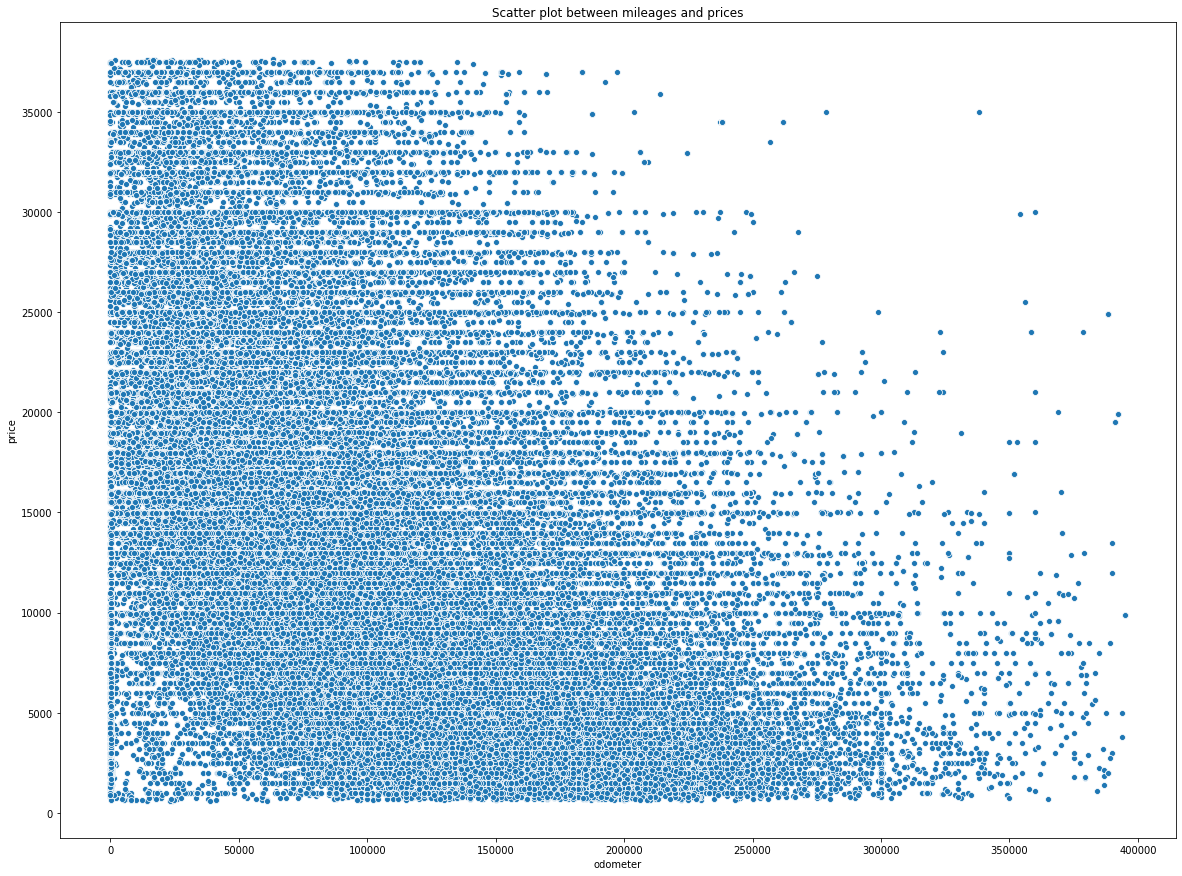

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot between mileages and prices')
sns.scatterplot(x='odometer', y='price', data=dataset)

The scatter plot shows that there are some cars with very less mileages(which are almost like new cars) sold for extremely lower prices. This is not possible in a real-world.

In [22]:
dataset = dataset[(dataset.price + dataset.odometer)>5000]

In [23]:
dataset.year.value_counts()

2015.0    15278
2017.0    14937
2014.0    14831
2013.0    14601
2016.0    14362
          ...  
1926.0        1
1925.0        1
1916.0        1
1942.0        1
1900.0        1
Name: year, Length: 98, dtype: int64

We have decided not to consider cars that are older than 1960 for our prediction.

In [24]:
dataset = dataset[dataset.year > 1960]

<h2>Removal of insufficient records</h2>

In [25]:
dataset_manu['manufacturer'].value_counts()

ford               55556
chevrolet          43592
toyota             26651
nissan             17740
honda              17254
jeep               15199
ram                14148
gmc                12889
dodge              10118
bmw                 9834
subaru              8501
hyundai             8222
volkswagen          7826
mercedes-benz       7191
kia                 6160
chrysler            4880
cadillac            4420
lexus               4399
buick               4271
mazda               4164
audi                3966
acura               2580
infiniti            2566
lincoln             2152
pontiac             1880
volvo               1876
mitsubishi          1848
mini                1606
rover               1191
mercury              877
saturn               872
fiat                 776
jaguar               708
harley-davidson      114
tesla                 68
alfa-romeo            49
datsun                33
land rover            20
porche                19
aston-martin          10


Some manufacturers have really less number of samples. So, we decided to keep only those manufacturers having greater than 100 records. Rest of the records will be removed from the dataset.

In [26]:
remove_manu = ['tesla','alfa-romeo', 'datsun', 'land rover', 'porche', 'aston-martin', 'morgan', 'ferrari']
for brand in remove_manu:
    dataset_manu = dataset_manu[~(dataset_manu['manufacturer'] == brand)]

In [27]:
dataset['model'].value_counts()

f-150                      3982
silverado 1500             2544
1500                       2031
silverado                  1630
camry                      1479
                           ... 
durango 5.7 hemi engine       1
silverado 1500 lt 4dr         1
200 convertible               1
camera - le                   1
528 xi                        1
Name: model, Length: 17781, dtype: int64

It is decided to remove the car models which have less than 50 samples.

In [28]:
dataset = dataset.groupby('model').filter(lambda x: len(x) > 50)

In [29]:
dataset['model'].value_counts()

f-150                          3982
silverado 1500                 2544
1500                           2031
silverado                      1630
camry                          1479
                               ... 
avalon xls                       51
sorento lx sport utility 4d      51
4 series 428i coupe 2d           51
trailblazer lt                   51
promaster 1500                   51
Name: model, Length: 562, dtype: int64

In [30]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119418 entries, 7 to 435848
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         119418 non-null  int64  
 1   year          119418 non-null  float64
 2   model         119418 non-null  object 
 3   condition     119418 non-null  object 
 4   cylinders     119418 non-null  object 
 5   fuel          119418 non-null  object 
 6   odometer      119418 non-null  float64
 7   transmission  119418 non-null  object 
 8   drive         119418 non-null  object 
 9   type          119418 non-null  object 
 10  paint_color   119418 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 10.9+ MB


In [31]:
dataset.to_csv('data_after_cleaning.csv')

<AxesSubplot:title={'center':'Count plot of all cars group by manufacturer'}, xlabel='manufacturer', ylabel='count'>

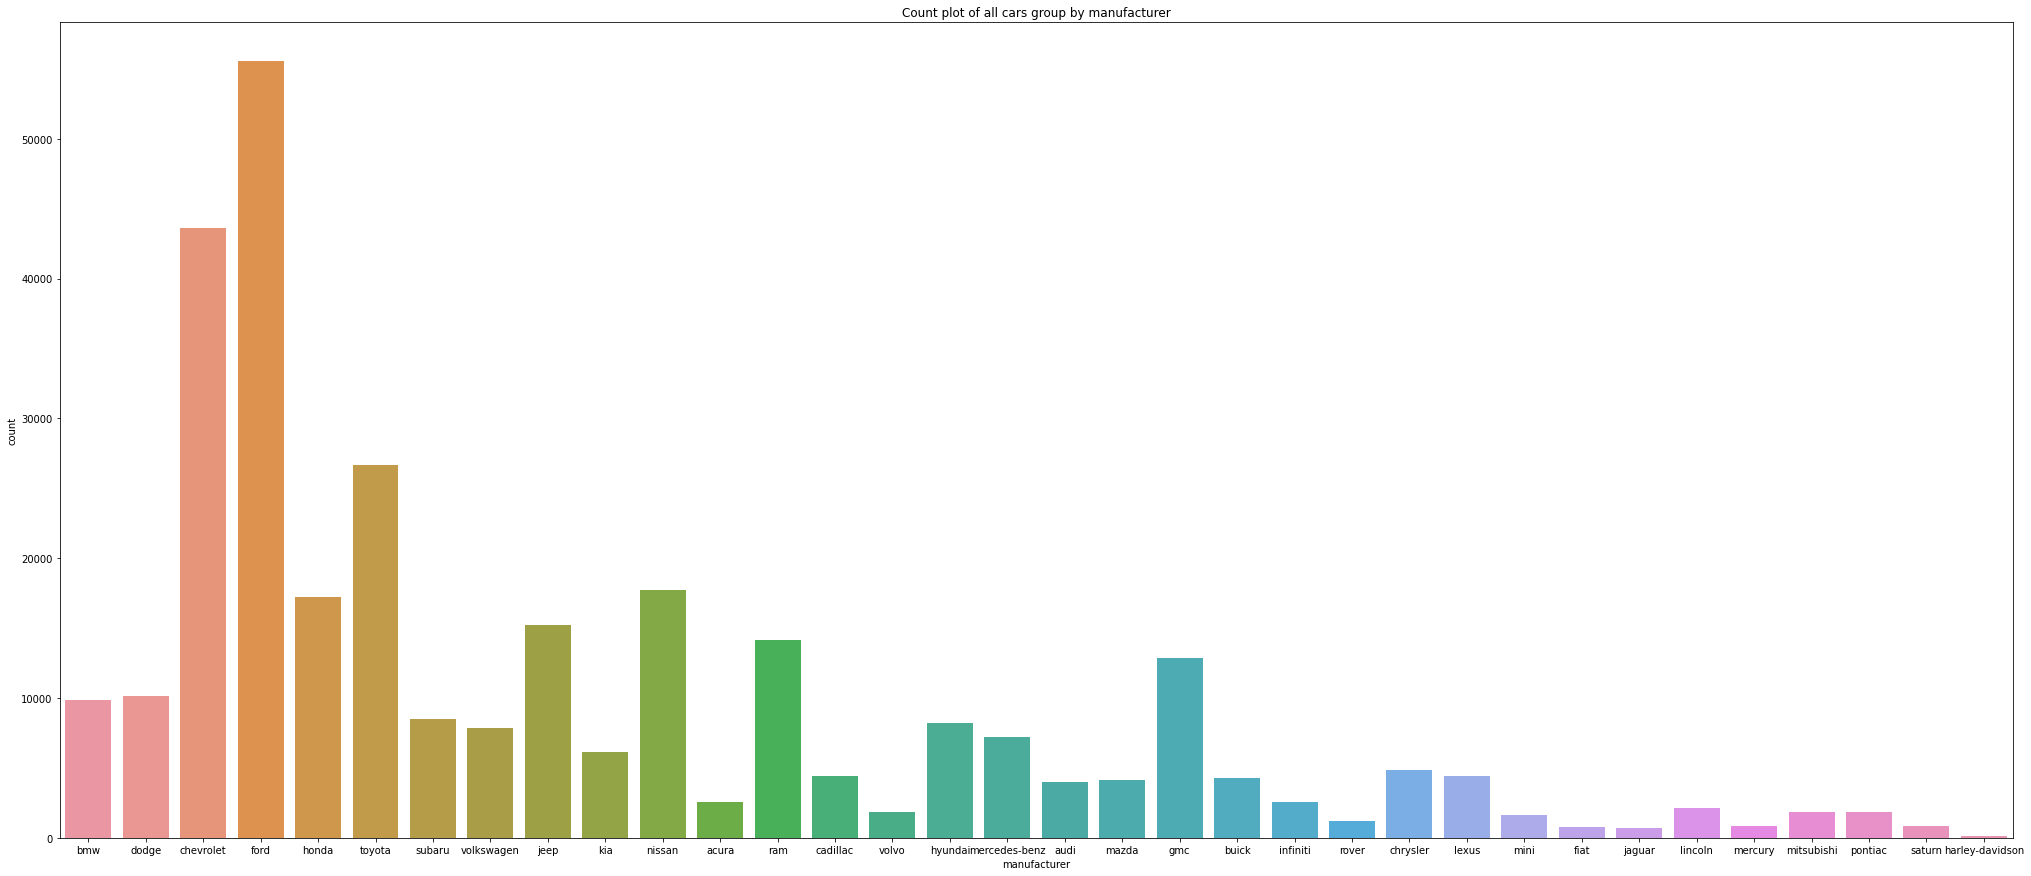

In [32]:
fig, ax = plt.subplots(figsize=(35,15))
ax.set_title('Count plot of all cars group by manufacturer')
sns.countplot(x='manufacturer', data=dataset_manu)